In [44]:
import pandas as pd
import numpy as np
import yfinance as yf
from ta.volatility import average_true_range as atr

SPX = yf.download('^GSPC', start='1990-01-01', end='2018-01-01')
RUA = yf.download('^RUA', start='1990-01-01', end='2018-01-01')
# price is already adjusted
SPX = SPX.drop(['Adj Close'], axis=1)
RUA = RUA.drop(['Adj Close'], axis=1)
# 10/200 MA
SPX['MA200'] = SPX['Close'].rolling(window=200).mean()
RUA['MA200'] = RUA['Close'].rolling(window=200).mean()
SPX['MA10'] = SPX['Close'].rolling(window=10).mean()
RUA['MA10'] = RUA['Close'].rolling(window=10).mean()
# ATR 10 for volatility
SPX['ATR10'] = atr(high=SPX['High'], low=SPX['Low'], close=SPX['Close'], window=10)
RUA['ATR10'] = atr(high=RUA['High'], low=RUA['Low'], close=RUA['Close'], window=10)
# Daily returns
SPX['Return'] = SPX['Close'].pct_change()
RUA['Return'] = RUA['Close'].pct_change()
# StDev of daily returns
SPX['StDev'] = SPX['Return'].rolling(10).std()
RUA['StDev'] = RUA['Return'].rolling(10).std()
# Side column if MA10 > MA200 1 (long), else -1 (short)
SPX['Side'] = np.where(SPX['MA10'] > SPX['MA200'], 1, -1) 
RUA['Side'] = np.where(RUA['MA10'] > RUA['MA200'], 1, -1)
# Shift side column forward by 1 so that we don't commit lookahead bias
SPX['Side'] = SPX['Side'].shift(1)
RUA['Side'] = RUA['Side'].shift(1)

SPX['StratReturns'] = 0
RUA['StratRetiuns'] = 0

for i, r in SPX.iterrows():
    # if side = 1, we get 'returns' column
    if r['Side'] == 1:
        SPX['StratReturns'][i] = r['Return']
    elif r['Side'] == -1:
        SPX['StratReturns'][i] = 0
    # else:
    #     SPX['StratReturns'][i] = 0

for i, r in RUA.iterrows():
    # if side = 1, we get 'returns' column
    if r['Side'] == 1:
        RUA['StratRetiuns'][i] = r['Return']
    elif r['Side'] == -1:
        RUA['StratRetiuns'][i] = 0
    # else:
    #     RUA['StratRetiuns'][i] = 0


# drop values for first 200 days since no MA200
SPX.dropna(inplace=True)
RUA.dropna(inplace=True)




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-44-c61e18edeb84>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPX['StratReturns'][i] = 0
<ipython-input-44-c61e18edeb84>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPX['StratReturns'][i] = r['Return']
<ipython-input-44-c61e18edeb84>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RUA['StratRetiuns'][i] = 0
<ipython-input-44-c61e18edeb84>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [49]:
from hmmlearn.hmm import GaussianHMM

##### HMM state 0 is bullish, 1 is bearish #####

rets = np.column_stack([SPX["Return"]])
hmm_model = GaussianHMM(n_components=2, covariance_type="ful", n_iter=10000).fit(rets)
hidden_states = hmm_model.predict(rets)
SPX['HMM_state'] = hidden_states

rets = np.column_stack([RUA["Return"]])
hmm_model = GaussianHMM(n_components=2, covariance_type="full", n_iter=10000).fit(rets)
hidden_states = hmm_model.predict(rets)
RUA['HMM_state'] = hidden_states



In [50]:
SPX[70:100]

,Open,High,Low,Close,Volume,MA200,MA10,ATR10,Return,StDev,Side,StratReturns,HMM_state,Cash
Date,,,,,,,,,,,,,,
1991-01-24,330.209991,335.829987,330.190002,334.779999,223150000,332.689600,324.218002,4.421153,0.013840,0.013429,-1.0,0.000000,0,727213.988974
1991-01-25,334.779999,336.920013,334.200012,336.070007,194350000,332.660350,326.302002,4.251038,0.003853,0.013383,-1.0,0.000000,0,727213.988974
1991-01-28,336.059998,337.410004,335.809998,336.029999,141270000,332.618800,328.656003,3.985935,-0.000119,0.012550,-1.0,0.000000,0,727213.988974
1991-01-29,336.029999,336.029999,334.260010,335.839996,155740000,332.574300,330.867001,3.764340,-0.000565,0.012767,-1.0,0.000000,0,727213.988974
1991-01-30,335.799988,340.910004,335.709991,340.910004,226790000,332.555450,333.341000,3.907908,0.015096,0.013029,-1.0,0.000000,0,727213.988974
1991-01-31,340.920013,343.929993,340.470001,343.929993,204520000,332.571500,334.937000,3.863116,0.008859,0.007938,1.0,0.008859,0,727213.988974
1991-02-01,343.910004,344.899994,340.369995,343.049988,246670000,332.596300,336.018997,3.929804,-0.002559,0.007672,1.0,-0.002559,0,727213.988974
1991-02-04,343.049988,348.709991,342.959991,348.339996,250750000,332.662400,337.746997,4.111824,0.015421,0.008142,1.0,0.015421,0,727213.988974
1991-02-05,348.339996,351.839996,347.209991,351.260010,290570000,332.763450,340.041998,4.163642,0.008383,0.006657,1.0,0.008383,0,727213.988974


In [31]:
SPX.tail()

,Open,High,Low,Close,Volume,MA200,MA10,ATR10,Return,StDev,Side
Date,,,,,,,,,,,
2017-12-22,2684.219971,2685.350098,2678.129883,2683.340088,2399830000,2476.090654,2673.356030,15.262749,-0.000458,0.003938,1.0
2017-12-26,2679.090088,2682.739990,2677.959961,2680.500000,1968780000,2477.625804,2675.407031,14.274487,-0.001058,0.003928,1.0
2017-12-27,2682.100098,2685.639893,2678.909912,2682.620117,2202080000,2479.211655,2677.258032,13.520036,0.000791,0.003919,1.0
2017-12-28,2686.100098,2687.659912,2682.689941,2687.540039,2153330000,2480.723055,2679.727026,12.672012,0.001834,0.003910,1.0
2017-12-29,2689.149902,2692.120117,2673.610107,2673.610107,2443490000,2482.184207,2681.887036,13.255812,-0.005183,0.004080,1.0


In [51]:
# backtest for long when Side is 1, cash when -1
# enter and exit on the Open
capital = 100000
SPX['Cash'] = capital
for i, r in SPX.iterrows():
    capital = capital * (1 + r['StratReturns'])
    SPX.loc[i, 'Cash'] = capital
capital



727213.9889743031

In [52]:
SPX

,Open,High,Low,Close,Volume,MA200,MA10,ATR10,Return,StDev,Side,StratReturns,HMM_state,Cash
Date,,,,,,,,,,,,,,
1990-10-15,300.029999,304.790009,296.410004,303.230011,164980000,338.926850,306.849002,6.506506,0.010666,0.013570,-1.0,0.000000,0,100000.000000
1990-10-16,303.230011,304.339996,298.119995,298.920013,149570000,338.623000,305.220004,6.477855,-0.014214,0.013842,-1.0,0.000000,0,100000.000000
1990-10-17,298.920013,301.500000,297.790009,298.760010,161260000,338.323000,303.956006,6.201069,-0.000535,0.013685,-1.0,0.000000,0,100000.000000
1990-10-18,298.750000,305.739990,298.750000,305.739990,204110000,338.073350,303.261005,6.279961,0.023363,0.016100,-1.0,0.000000,0,100000.000000
1990-10-19,305.739990,312.480011,305.739990,312.480011,221480000,337.874750,303.359006,6.325967,0.022045,0.017788,-1.0,0.000000,0,100000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,2684.219971,2685.350098,2678.129883,2683.340088,2399830000,2476.090654,2673.356030,15.262749,-0.000458,0.003938,1.0,-0.000458,1,729860.514692
2017-12-26,2679.090088,2682.739990,2677.959961,2680.500000,1968780000,2477.625804,2675.407031,14.274487,-0.001058,0.003928,1.0,-0.001058,1,729088.019242
2017-12-27,2682.100098,2685.639893,2678.909912,2682.620117,2202080000,2479.211655,2677.258032,13.520036,0.000791,0.003919,1.0,0.000791,1,729664.684805


<AxesSubplot:xlabel='Date'>

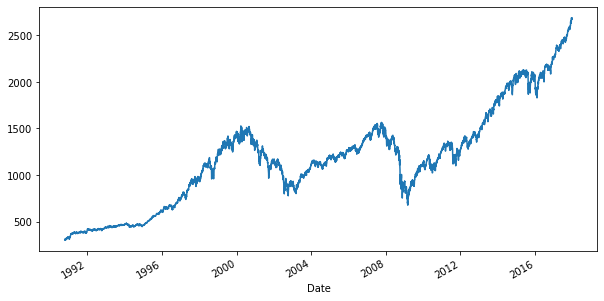

In [14]:
# plot SPX returns
SPX['Close'].plot(figsize=(10,5))

<AxesSubplot:xlabel='Date'>

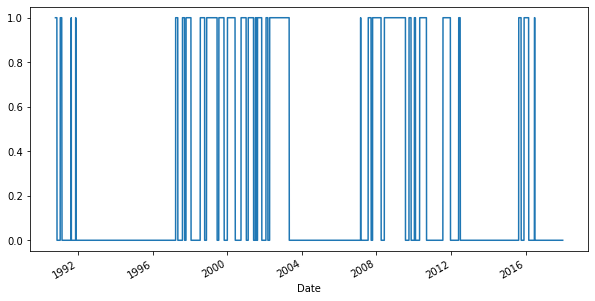

In [17]:
# plot state of HMM at SPX price
SPX['HMM_state'].plot(figsize=(10,5))